# Toggle_Switch

In [1]:
import numpy as np
import gillespy2
from gillespy2.core import Model, Species, Reaction, Parameter, RateRule


In [2]:
class Toggle_Switch(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Toggle_Switch")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="alpha1", expression=1))
        self.add_parameter(Parameter(name="alpha2", expression=1))
        self.add_parameter(Parameter(name="beta", expression=2))
        self.add_parameter(Parameter(name="gamma", expression=2))
        self.add_parameter(Parameter(name="mu", expression=1))

        # Species
        self.add_species(Species(name="A", initial_value=10, mode="dynamic"))
        self.add_species(Species(name="B", initial_value=10, mode="dynamic"))

        # Reactions
        self.add_reaction(Reaction(name="cu", reactants={}, products={'A': 1}, propensity_function="alpha1/(1+pow(B, beta))"))
        self.add_reaction(Reaction(name="cv", reactants={}, products={'B': 1}, propensity_function="alpha2/(1+pow(A, gamma))"))
        self.add_reaction(Reaction(name="du", reactants={'A': 1}, products={}, rate=self.listOfParameters["mu"]))
        self.add_reaction(Reaction(name="dv", reactants={'B': 1}, products={}, rate=self.listOfParameters["mu"]))

        # Timespan
        self.timespan(np.linspace(0, 250, 251))

In [3]:
model = Toggle_Switch()

In [4]:
results = model.run(seed=None)

In [5]:
results.plotplotly()

In [6]:
# Feature extraction function.  What value(s) do you want to extract
# from the simulation trajectory

def population_at_last_timepoint(c,res):
    if c.verbose: print('population_at_last_timepoint {0}={1}'.format(c.species_of_interest,result1[c.species_of_interest][-1]))
    return res[c.species_of_interest][-1]

# Aggregation function, How to we combine the values from multiple 
# trajectores

def average_of_ensemble(c,data):
    a=np.average(data)
    if c.verbose: print('average_of_ensemble = {0}'.format(a))
    return a

In [7]:
class ParameterSweep2D():
    
    def run(c, verbose=False):
        c.verbose = verbose
        fn = c.feature_extraction
        ag = c.ensemble_aggragator
        data = np.zeros((len(c.p1_range),len(c.p2_range)))
        for i,v1 in enumerate(c.p1_range):
            for j,v2 in enumerate(c.p2_range):
                tmp_model = c.ps_class()
                tmp_model.listOfParameters[c.p1].set_expression(v1)
                tmp_model.listOfParameters[c.p2].set_expression(v2)
                if verbose: print("running {0}={1}, {2}={3}".format(c.p1,v1,c.p2,v2))
                #if verbose: print("\t{0}".format(["{0}={1}, ".format(k,v.value) for k,v in tmp_model.listOfParameters.items()]))
                if(c.number_of_trajectories > 1):
                    tmp_results = tmp_model.run(number_of_trajectories=c.number_of_trajectories)
                    data[i,j] = ag([fn(x) for x in tmp_results])
                else:
                    tmp_result = tmp_model.run()
                    data[i,j] = c.feature_extraction(tmp_result)
        c.data = data      
        
    def plot(c):
        from matplotlib import pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        import numpy
        fig, ax = plt.subplots(figsize=(8,8))
        plt.imshow(c.data)
        ax.set_xticks(numpy.arange(c.data.shape[1])+0.5, minor=False)
        ax.set_yticks(numpy.arange(c.data.shape[0])+0.5, minor=False)
        plt.title("Parameter Sweep - Species: {0}".format(c.species_of_interest))
        ax.set_xticklabels(c.p1_range, minor=False, rotation=90)
        ax.set_yticklabels(c.p2_range, minor=False)
        ax.set_xlabel(c.p1, fontsize=16, fontweight='bold')
        ax.set_ylabel(c.p2, fontsize=16, fontweight='bold')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        _ = plt.colorbar(ax=ax, cax=cax)
    

In [8]:
# Configuration for the Parameter Sweep
class ParameterSweepConfig(ParameterSweep2D):
    p1 = 'alpha1'
    p2 = 'alpha2'
    p1_range = np.linspace(1,10,10)
    p2_range = np.linspace(1,10,10)
    species_of_interest = 'A'
    number_of_trajectories = 10
    # What feature of the simulation are we examining
    feature_extraction = population_at_last_timepoint
    # for number_of_trajectories > 1: how do we aggreggate the values
    ensemble_aggragator = average_of_ensemble
    # What class defines the GillesPy2 model
    ps_class = Toggle_Switch


In [9]:
ps = ParameterSweepConfig();
%time ps.run()

CPU times: user 987 ms, sys: 1.21 s, total: 2.2 s
Wall time: 3min 18s


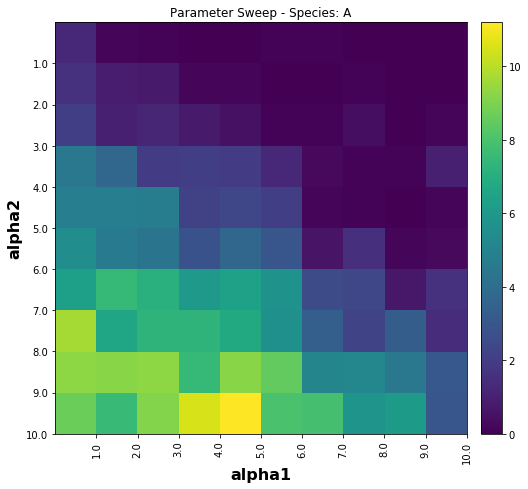

In [11]:
ps.plot()